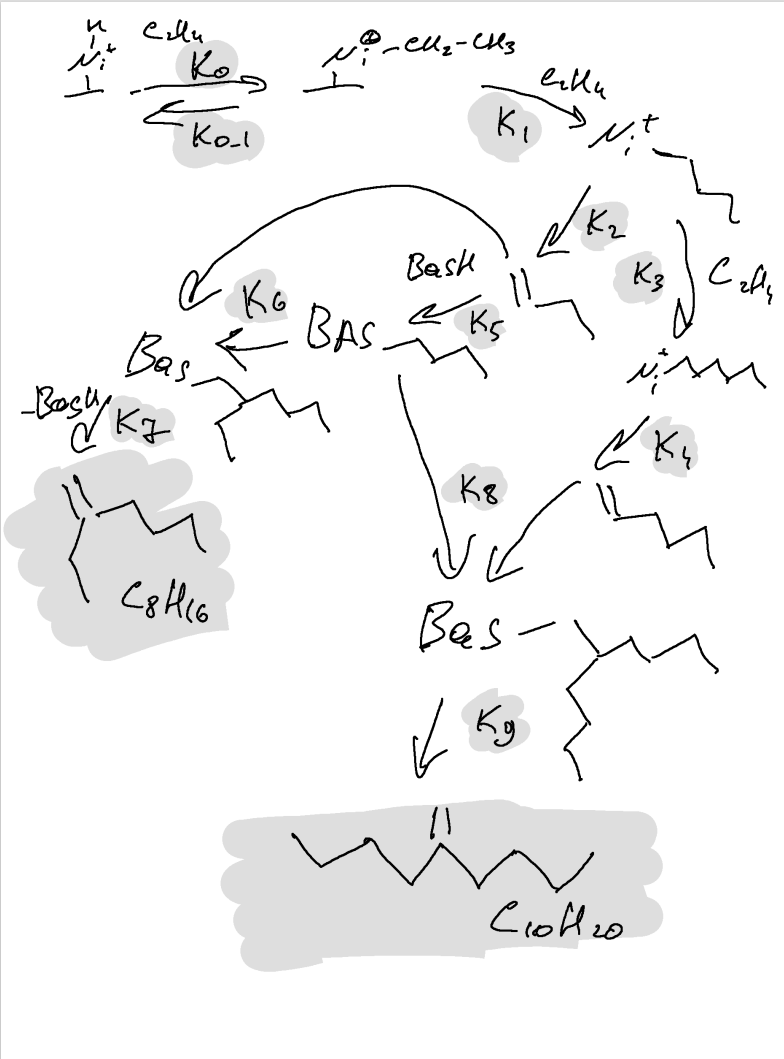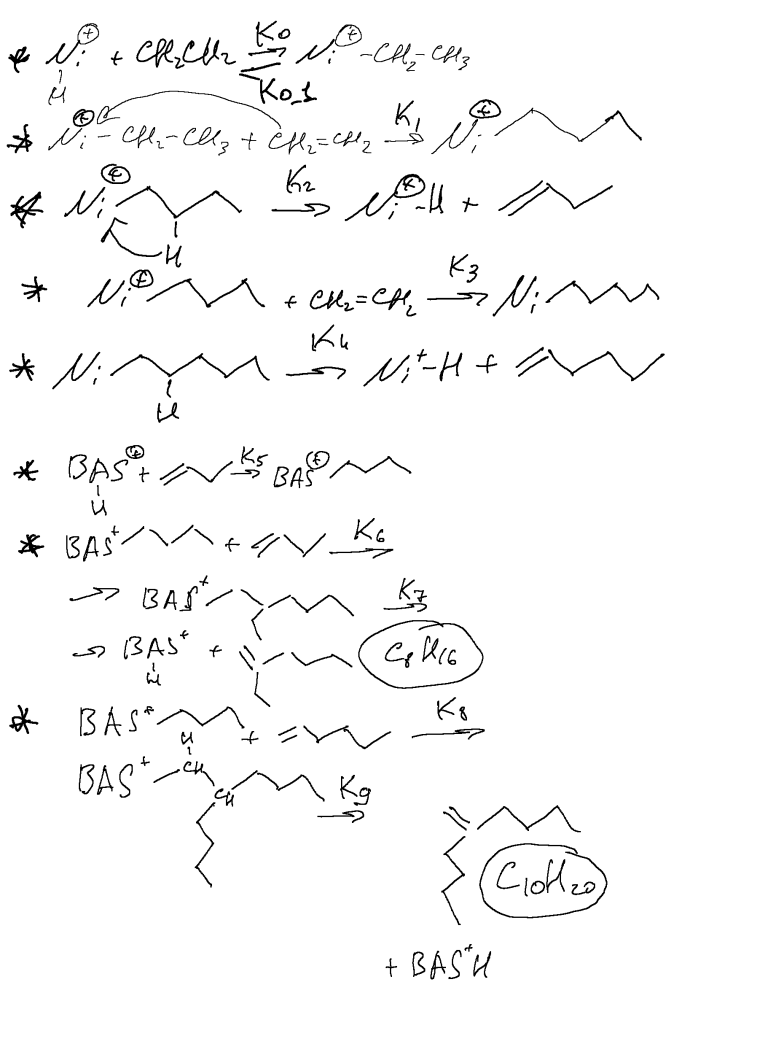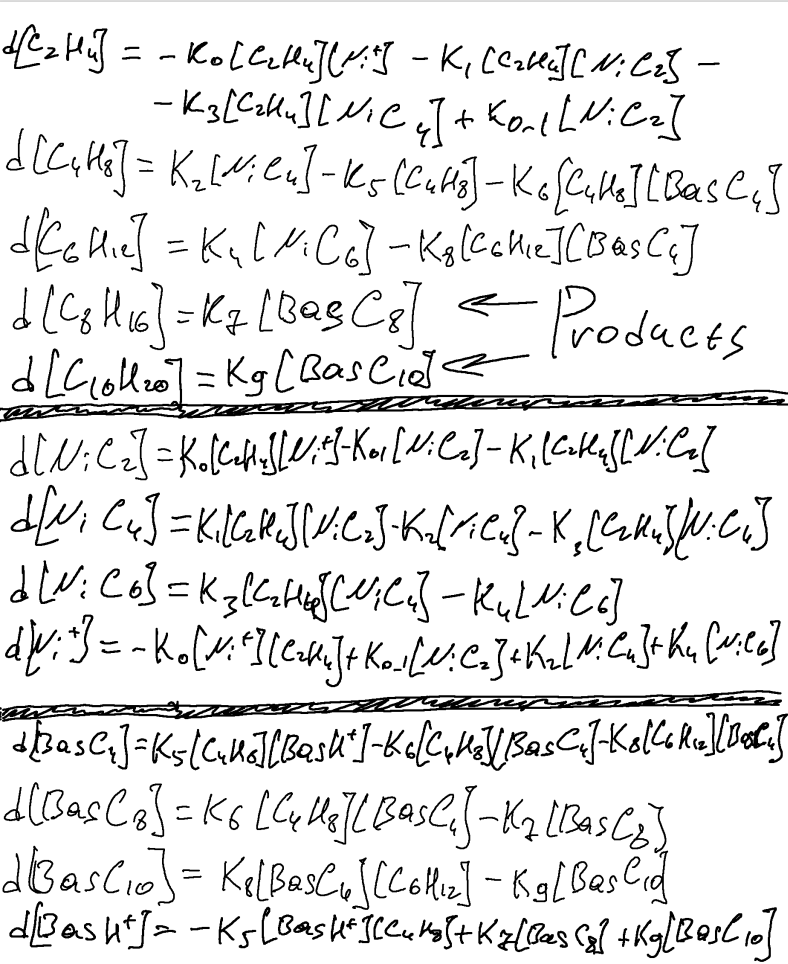   
https://doi.org/10.1016/j.cattod.2015.11.032

<Axes: >

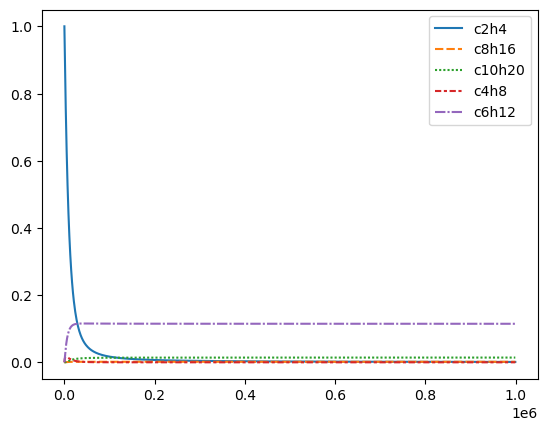

In [66]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def polymerization(dydt, t, 
                   k0, k0_1, k1, k2, k3, k4, 
                   k5, k5_0, k6, k7, k8, k9,
                   Dc4h8, Dc6h12, stream_mode=False):
    
    c2h4, c4h8, c6h12, c8h16, c10h20,\
        nip, nic2, nic4, nic6, \
        basp, basc4, basc8, basc10 = dydt
    
    dc2h4 = 0 if stream_mode else -k0 * c2h4 * nip - k1 * c2h4 * nic2 - k3 * c2h4 * nic4 + k0_1 * nic2
    dc4h8 = k2 * nic4 - k5 * c4h8 - k6 * c4h8 * basc4 - Dc4h8 * c4h8 + k5_0 * basc4
    dc6h12 = k4 * nic6 - k8 * c6h12 * basc4 - Dc6h12 * c6h12
    dc8h16 = k7 * basc8
    dc10h20 = k9 * basc10

    dnip = -k0 * c2h4 * nip + k0_1 * nic2 + k2 * nic4 + k4 * nic6
    dnic2 = k0 * c2h4 * nip - k0_1 * nic2 - k1 * c2h4 * nic2
    dnic4 = k1 * c2h4 * nic2 - k2 * nic4 - k3 * c2h4 * nic4
    dnic6 = k3 * c2h4 * nic4 - k4 * nic6

    dbasp = -k5 * basp * c4h8 + k5_0 * basc4 + k7 * basc8 + k9 * basc10
    dbasc4 = k5 * c4h8 * basp - k6 * c4h8 * basc4 - k8 * c6h12 * basc4 - k5_0 * basc4
    dbasc8 = k6 * c4h8 * basc4 - k7 * basc8
    dbasc10 = k8 * basc4 * c6h12 - k9 * basc10

    return [dc2h4, dc4h8, dc6h12, dc8h16, dc10h20,\
        dnip, dnic2, dnic4, dnic6, \
        dbasp, dbasc4, dbasc8, dbasc10]


def simulate_polymerization(total_time=10000, dt=0.1, c2h4=1e-1, Dc4h8=0, Dc6h12=0, nip=0.05, basp=0.1, stream_mode=True):
    # kinetic constants
    k0 = 1e-3
    k0_1 = 1e-3
    k1 = 1e-2
    k2 = 1e-2
    k3 = 1e-2
    k4 = 1e-2
    k5 = 1e-3
    k5_0 = 1e-3
    k6 = 1e-2
    k7 = 1e-2
    k8 = 1e-2
    k9 = 1e-2
    
    # Начальные концентрации
    c4h8, c6h12, c8h16, c10h20,\
    nip, nic2, nic4, nic6, \
    basp, basc4, basc8, basc10 = 0, 0, 0, 0, \
                                nip, 0, 0, 0, \
                                basp, 0, 0, 0


    t = np.arange(0, total_time, dt)

    result = odeint(polymerization, 
                    [c2h4, c4h8, c6h12, c8h16, c10h20, nip, nic2, nic4, nic6, basp, basc4, basc8, basc10], t, 
                    args=(k0, k0_1, k1, k2, k3, k4, k5, k5_0, k6, k7, k8, k9, Dc4h8, Dc6h12, stream_mode))

    df = pd.DataFrame(result, columns=['c2h4', 'c4h8', 'c6h12', 'c8h16', 'c10h20',
                                    'nip', 'nic2', 'nic4', 'nic6', 
                                    'basp', 'basc4', 'basc8', 'basc10'])

    df.index = t
    df['time'] = t

    return df


df = simulate_polymerization(total_time=1000_000, dt=0.1, c2h4=1, Dc4h8=0, Dc6h12=0, stream_mode=False)
sns.lineplot(data=df.drop(columns=('time')).loc[::10000, ['c2h4', 'c8h16', 'c10h20', 'c4h8', 'c6h12']])

<Axes: >

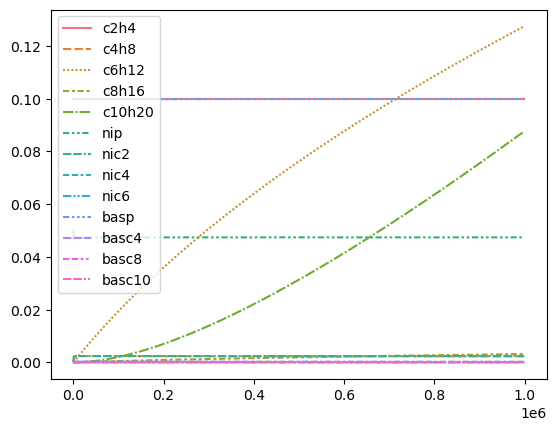

In [68]:
df = simulate_polymerization(total_time=1000_000, dt=0.1, c2h4=0.1, Dc4h8=0, Dc6h12=0, stream_mode=True)
sns.lineplot(data=df.drop(columns=['time'])[::10000])

Selectivity:   9.174


<Axes: >

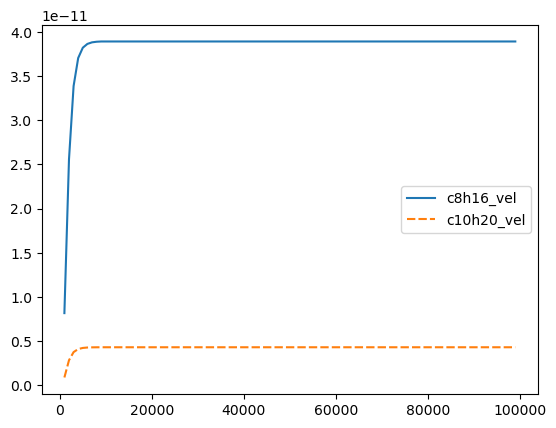

In [72]:
t = 100_000
df = simulate_polymerization(total_time=t, dt=0.1, Dc4h8=1e-2, Dc6h12=1e-2, stream_mode=True)

df['c8h16_vel'] = df['c8h16'].diff().iloc[1:] / df['time'].diff().iloc[1:]
df['c10h20_vel'] = df['c10h20'].diff().iloc[1:] / df['time'].diff().iloc[1:]
selectiv = df.loc[t * 9 // 10:, ['c8h16_vel']].mean()[0]/df.loc[t * 9 // 10:, ['c10h20_vel']].mean()[0]
print('Selectivity: {:7.3f}'.format(selectiv))

sns.lineplot(data=df.loc[::t//10, ['c8h16_vel', 'c10h20_vel']])

In [73]:
df.loc[20_000: 60_000, 'c8h16_vel'].std(), df.loc[: 10_000, 'c8h16_vel'].std()

(2.929214424040672e-18, 1.1949718376367298e-11)

In [74]:
from tqdm import tqdm

def get_vel(total_time=1000_000, dt=0.1, Dc4h8=1e-2, Dc6h12=1e-2):
    df = simulate_polymerization(total_time=total_time, dt=dt, Dc4h8=Dc4h8, Dc6h12=Dc6h12, stream_mode=True)

    df['c8h16_vel'] = df['c8h16'].diff().iloc[1:] / df['time'].diff().iloc[1:]
    df['c10h20_vel'] = df['c10h20'].diff().iloc[1:] / df['time'].diff().iloc[1:]
    
    dc8h16 = df.loc[total_time * 9 // 10:, ['c8h16_vel']].mean()[0]
    dc10h20 = df.loc[total_time * 9 // 10:, ['c10h20_vel']].mean()[0]
    std_c8h16 = df.loc[total_time * 9 // 10:, ['c8h16_vel']].std()[0]
    std_c10h20 = df.loc[total_time * 9 // 10:, ['c10h20_vel']].std()[0]

    return dc8h16, dc10h20, std_c8h16, std_c10h20, dc8h16/dc10h20

total_time = 100_000
Dc4h8 = [1e-4, 1e-3, 1e-2, 1e-1, 1]
Dc6h12 = [1e-4, 1e-3, 1e-2, 1e-1, 1]
df = pd.DataFrame()

with tqdm(total=len(Dc4h8)*len(Dc6h12)) as pbar:
    for d4 in Dc4h8:
        for d6 in Dc6h12:
            c8h16, c10h20, std_c8h16, std_c10h20, selectivity = get_vel(total_time, dt=0.1, Dc4h8=d4, Dc6h12=d6)
            pbar.update(1)
            dft = pd.DataFrame({'dc8h16': [c8h16], 'dc10h20': [c10h20], 'c8h16_std': [std_c8h16], 
                               'c10h20_std': [std_c10h20], 'D4': [d4], 'D6': [d6], 'selectivity': [selectivity]})
            df = pd.concat([df, dft])

df[df.c8h16_std > 1e-12]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


,dc8h16,dc10h20,c8h16_std,c10h20_std,D4,D6,selectivity


C:\Users\lt0828\AppData\Local\Temp\ipykernel_21704\3841341222.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df.pivot("D4", "D6", "selectivity")


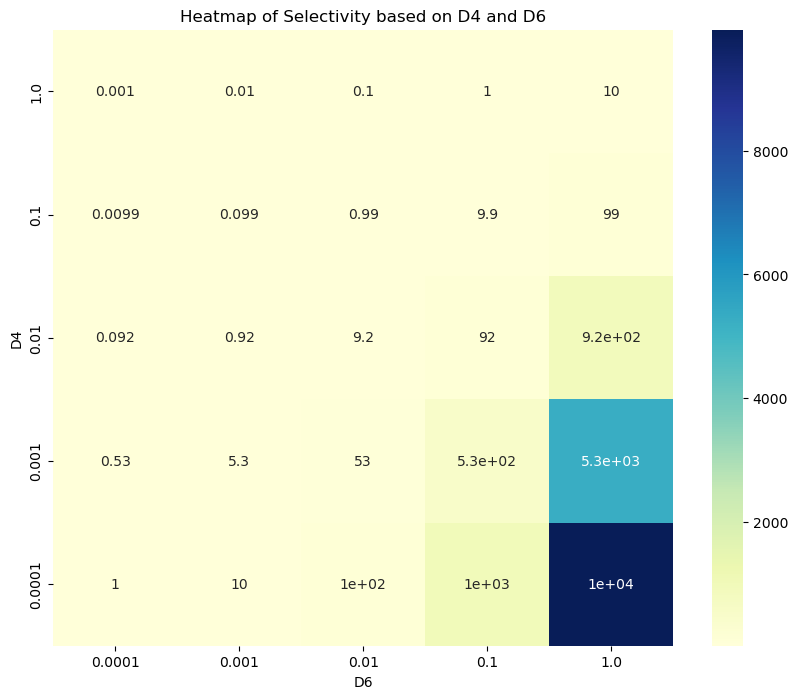

In [75]:
heatmap_data = df.pivot("D4", "D6", "selectivity")

# Строим тепловую карту
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")  # annot=True будет отображать значения в каждой ячейке
plt.title("Heatmap of Selectivity based on D4 and D6")
plt.gca().invert_yaxis()
plt.show()